In [2]:
!pip install alexnet_pytorch
from alexnet_pytorch import AlexNet
import json
import torch
import torchvision.transforms as transforms
from PIL import Image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/image_pro')
%cd /content/drive/MyDrive/Colab Notebooks/image_pro

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/image_pro


In [2]:
if torch.cuda.is_available():
  print(3)

3


In [3]:
# define model parameters
NUM_EPOCHS = 20 
BATCH_SIZE = 64
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 227  # pixels
NUM_CLASSES = 2  #number of bit
DEVICE_IDS = [0, 1, 2,3]  # GPUs to use
#DEVICE_IDS = [0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet.from_pretrained('alexnet',num_classes=2).to(device)
model.eval()

# modify this to point to your data directory
ROOT = r'/content/drive/MyDrive/Colab Notebooks/image_pro/'
#INPUT_ROOT_DIR = 'alexnet_data_in'
TRAIN_IMG_DIR = ROOT+'datasets_post/train'
TEST_IMG_DIR = ROOT+'datasets_post/test'
VALI_IMG_DIR = ROOT+'datasets_post/vali'
OUTPUT_DIR = ROOT+'result'

LOG_DIR = OUTPUT_DIR + '/tblogs'  # tensorboard logs
CHECKPOINT_DIR = OUTPUT_DIR + '/models'  # model checkpoints

Loaded pretrained weights for alexnet


In [4]:
# print the seed value
seed = torch.initial_seed()
print('Used seed : {}'.format(seed))
#tbwriter = SummaryWriter(log_dir=LOG_DIR)
#print('TensorboardX summary writer created')


Used seed : 15126668862055365485


In [5]:
means=[0.485, 0.456, 0.406]
stds=[0.229, 0.224, 0.225]

In [5]:
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                             train = True, 
                             download = True)

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

Files already downloaded and verified


In [6]:
train_transforms = transforms.Compose([
                                       transforms.Resize(800),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                          #  transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])
test_transforms = transforms.Compose([
                                      transforms.Resize(800),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [7]:
def fetchData():
    '''
    fetch data from file.
    @return: train, test and valid dataset
    '''
    train_path = TRAIN_IMG_DIR # edit me
    valid_path = VALI_IMG_DIR # edit me
    test_path = TEST_IMG_DIR
    train_data = datasets.ImageFolder(train_path, transform=train_transforms)
    valid_data = datasets.ImageFolder(valid_path, transform=test_transforms)
    test_data = datasets.ImageFolder(test_path, transform=test_transforms)
    return train_data, valid_data, test_data
    #return train_data,test_path



train_data,valid_data,test_data = fetchData()
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': len(DEVICE_IDS)}

train_loader = torch.utils.data.DataLoader(train_data, **params)
vali_loader = torch.utils.data.DataLoader(valid_data,**params)
test_loader = torch.utils.data.DataLoader(test_data,**params)

In [8]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=5e-2)
# multiply LR by 1 / 10 after every 30 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
print('LR Scheduler created')
# start training!!
print('Starting training...')
total_steps = 1
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

def save_model(model, filename):
    filename = os.path.join("checkpoints", filename + ".pth")
    dirname = os.path.dirname(filename)
    os.makedirs(dirname, exist_ok=True)
    torch.save(model.state_dict(), filename)
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

best_valid_loss = float('inf')

LR Scheduler created
Starting training...


In [11]:
for epoch in range(NUM_EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, vali_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')




Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 0.424 | Train Acc: 80.63%
	 Val. Loss: 0.905 |  Val. Acc: 50.19%
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.261 | Train Acc: 90.15%
	 Val. Loss: 1.380 |  Val. Acc: 51.71%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.229 | Train Acc: 90.66%
	 Val. Loss: 1.525 |  Val. Acc: 50.58%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.201 | Train Acc: 93.10%
	 Val. Loss: 1.145 |  Val. Acc: 51.91%
Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.178 | Train Acc: 93.53%
	 Val. Loss: 1.359 |  Val. Acc: 52.16%
Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 0.174 | Train Acc: 93.89%
	 Val. Loss: 1.771 |  Val. Acc: 50.31%
Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.176 | Train Acc: 93.50%
	 Val. Loss: 1.741 |  Val. Acc: 52.32%
Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.167 | Train Acc: 93.28%
	 Val. Loss: 2.262 |  Val. Acc: 50.35%
Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.171 | Train Acc: 93.92%
	 Val. Loss: 1.383 |  Val. Acc: 51.52%
Epoch: 10 | Epoch T

In [10]:
torch.save(model,'/content/drive/MyDrive/Colab Notebooks/image_pro/test_2.pt')

In [14]:
ok=torch.load('test_2.pt')
#model.load_state_dict(ok)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.319 | Test Acc: 90.18%


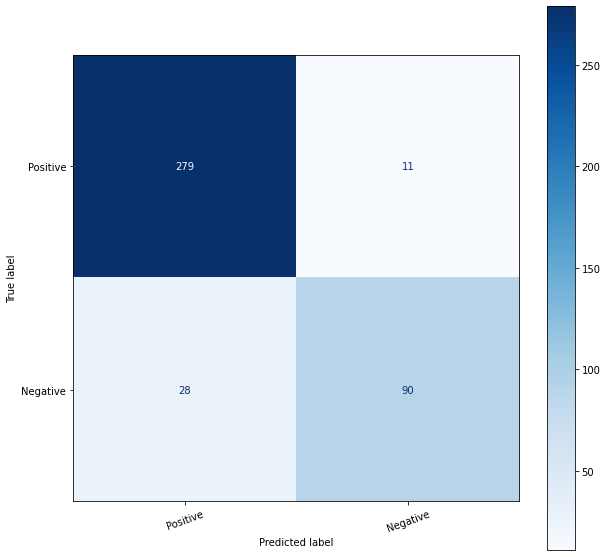

In [13]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            # images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    #images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs
images, labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
plot_confusion_matrix(labels, pred_labels, ['Positive','Negative'])

https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb